In [9]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [3]:
%run C:\Users\Sahana\Aggression-Detection\paths.py 
CONST = CONST()

In [110]:
train = pd.read_csv(CONST.CLEANED_TRAIN)
test = pd.read_csv(CONST.CLEANED_TEST)
train.head()
train_x = train['tweet']
train_y = train['class']
test_x = test['tweet']
test_y = test['class']

In [7]:
%run C:\Users\Sahana\Aggression-Detection\src\processing\glove_utils.py
vocab = build_vocab(list(train_x.apply(lambda x:x.split())))
len(vocab)



27105

In [10]:
%run C:\Users\Sahana\Aggression-Detection\src\processing\glove_utils.py
glove_embed = load_embed(CONST.GLOVE_100d)

   

In [38]:
glove_embed['the']

array([ 9.5152e-02,  3.7024e-01,  5.4291e-01,  1.9621e-01,  4.8205e-02,
        3.2033e-01, -5.9638e-01,  1.5868e-02, -1.2989e-01, -6.3028e-01,
        8.1944e-02,  2.4164e-01, -6.0990e+00, -6.8557e-01,  5.0354e-01,
       -3.4089e-02,  1.1705e-01, -7.7403e-03, -8.6512e-02,  4.3617e-01,
       -4.3982e-01,  2.6125e-01, -4.0348e-02, -1.9194e-01,  8.3204e-02,
       -5.8246e-01, -3.1923e-02,  1.2630e-01,  4.0120e-01,  6.8906e-02,
       -1.0517e-01, -2.0804e-01, -4.2554e-01,  4.7799e-01,  3.4651e-01,
        2.4057e-01,  5.0244e-02, -7.2587e-02, -2.4347e-03, -5.0342e-01,
       -1.0601e+00, -3.1586e-01, -3.2457e-02, -7.6317e-02,  7.9045e-01,
        8.6367e-02, -1.9632e-01,  5.7566e-02,  8.4129e-01, -4.2020e-01,
       -1.1335e-03, -8.5632e-02,  6.1910e-02,  2.1423e-01, -1.0356e-01,
       -3.6946e-02, -2.6005e-01, -3.5657e-01,  5.4321e-02,  3.0875e-02,
        1.4092e-01, -9.1998e-02, -4.1841e-01, -3.1135e-01, -1.4937e-01,
       -2.2699e-04, -3.3454e-01, -1.4848e-01, -1.1944e-01, -2.71

In [18]:
train['total_length'].median()

39.0

In [19]:
train['total_length'].mean()

43.445371162437034

In [24]:
train['total_length'].max()

277

In [33]:
df = train[train['total_length']<100]
print(df['tweet'].count())

41092


In [11]:
MAX_SEQ_LEN = 100
MAX_NUM_WORDS = 20000
EMBED_DIM = 100




In [12]:
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer.fit_on_texts(list(train_x) + list(test_x))
print(len(tokenizer.word_index))
print("Word index:",tokenizer.word_index)


train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)


30803
Word index: {'bitch': 1, 'not': 2, 'face': 3, 'bitches': 4, 'out': 5, 'hoes': 6, 'get': 7, 'no': 8, 'with': 9, 'pussy': 10, 'was': 11, 'ass': 12, 'hoe': 13, 'got': 14, 'happy': 15, 'fuck': 16, 'these': 17, 'of': 18, 'can': 19, 'joy': 20, 'tears': 21, 'love': 22, 'laughing': 23, 'shit': 24, 'some': 25, 'cannot': 26, 'go': 27, 'see': 28, 'good': 29, 'nigga': 30, 'know': 31, 'people': 32, 'time': 33, 'trash': 34, 'want': 35, 'loud': 36, 'more': 37, 'them': 38, 'why': 39, 'his': 40, 'would': 41, 'make': 42, 'life': 43, 'you': 44, 'smile': 45, 'because': 46, 'too': 47, 'back': 48, 'need': 49, 'really': 50, 'never': 51, 'think': 52, 'niggas': 53, 'it': 54, 'still': 55, 'man': 56, 'sad': 57, 'right': 58, 'going': 59, 'look': 60, 'being': 61, 'did': 62, 'me': 63, 'even': 64, 'bad': 65, 'had': 66, 'say': 67, 'e': 68, 'fucking': 69, 'over': 70, 'day': 71, 'than': 72, 'yo': 73, 'hate': 74, 'first': 75, 'way': 76, 'come': 77, 'always': 78, 'girl': 79, 'down': 80, 'fathers': 81, 'im': 82, 'be

In [13]:

#default is pre-padding, can try with post paddding
train_X = pad_sequences(train_x, maxlen = MAX_SEQ_LEN)
test_X = pad_sequences(test_x, maxlen = MAX_SEQ_LEN)


In [15]:

#prepare the embedding matrix

num_words = MAX_NUM_WORDS
embedding_matrix = np.zeros((num_words, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = glove_embed.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [16]:
embedding_matrix.shape

(20000, 100)

In [23]:
#deep learning imports

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D , Dense , Dropout, concatenate , Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from numpy import random
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [76]:



class textCNN:
    def __init__(self,sequence_len, max_words, no_classes, embed_dim, filter_size,no_filters,hidden_dims,drop_rate):
        self.sequence_len = sequence_len
        self.max_words = max_words
        self.no_classes = no_classes
        self.embed_dim = embed_dim
        self.filter_size = filter_size
        self.no_filters = no_filters
        self.hidden_dims = hidden_dims
        self.drop_rate = drop_rate


    def cnn_model(self):
        inp = Input(shape = (self.sequence_len,) , name = 'inp')
        embed = Embedding(self.max_words, self.embed_dim, weights = [embedding_matrix], input_length = self.sequence_len ,trainable = True  )(inp)
       
        #keep low drop out rate for input
        embed = Dropout(0.2)(embed)
                
        x = self.conv_layer(embed)
        x = Activation('relu')(x)
        output = Dense(self.no_classes, activation='softmax')(x)
        return Model(inputs = inp, outputs = output)

    
 
    
    def conv_layer(self, embed): 
        conv_channels = []
        for i in range(len(self.filter_size)):
            channel = self.each_conv_channel(embed, self.no_filters, self.filter_size[i])
            conv_channels.append(channel)
            if (len(conv_channels)>1):                
                channel = keras.layers.concatenate(conv_channels)
        
        return channel
        
    def each_conv_channel(self, embed, no_filters, filter_size):
        x = Conv1D(no_filters, kernel_size = filter_size, activation = 'relu', strides=1, padding='valid')(embed)
        x = GlobalMaxPooling1D()(x)
            #hidden dense layer
        x = Dense(self.hidden_dims)(x)
        x = Dropout(self.drop_rate)(x)
        return x
        
    
    

Model training with 2 fold cross validation

In [98]:
#from textCNN import textCNN

#deep learning parameters
filter_sizes = [3,4,5]
num_filters = 10
dropout_rate = 0.5
hidden_dense_units = 20


#training parameters
no_folds = 2
batch_size = 100
epochs = 5
#lr = 0.001


#train_X test_X train_y test_y

model_history = []




#model_checkpoint = ModelCheckpoint('cnn_text.h5',monitor='val_loss', verbose=1, save_best_only=True)
def fit_eval(tr_x, val_x, tr_y, val_y):
    model= None
    model = textCNN(    
    sequence_len = MAX_SEQ_LEN,
    max_words = MAX_NUM_WORDS,
    no_classes = 2,
    embed_dim = EMBED_DIM,
    filter_size = filter_sizes,
    no_filters = num_filters,
    hidden_dims = hidden_dense_units,
    drop_rate = dropout_rate    
    ).cnn_model()
    
    model.summary()
    model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    result = model.fit(tr_x, tr_y, epochs = epochs, batch_size = batch_size, callbacks = [EarlyStopping(monitor='loss', patience = 3, verbose = 1) , ModelCheckpoint('cnn_text.h5',monitor='loss', verbose=1, save_best_only=True)], 
              verbose=1 , validation_data=(val_x, val_y))  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return result
    
    
for i in range(no_folds):
    print("Training on fold ",i+1)
    tr_x, val_x, tr_y, val_y = train_test_split(train_X, tf.keras.utils.to_categorical(train_y), test_size = 0.1, random_state = np.random.randint(1,1000))
    model_history.append(fit_eval(tr_x, val_x, tr_y, val_y))
    



    
   

Training on fold  1
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 100, 100)     2000000     inp[0][0]                        
__________________________________________________________________________________________________
dropout_60 (Dropout)            (None, 100, 100)     0           embedding_25[0][0]               
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 98, 10)       3010        dropout_60[0][0]                 
_______________________________________________________________________

Train on 37875 samples, validate on 4209 samples
Epoch 1/5
37875/37875 [==============================] - 57s 2ms/step - loss: 0.2998 - acc: 0.8827 - val_loss: 0.1906 - val_acc: 0.9316

Epoch 00001: loss improved from inf to 0.29982, saving model to cnn_text.h5
Epoch 2/5
37875/37875 [==============================] - 55s 1ms/step - loss: 0.1865 - acc: 0.9349 - val_loss: 0.1741 - val_acc: 0.9351

Epoch 00002: loss improved from 0.29982 to 0.18649, saving model to cnn_text.h5
Epoch 3/5
37875/37875 [==============================] - 55s 1ms/step - loss: 0.1588 - acc: 0.9439 - val_loss: 0.1711 - val_acc: 0.9387

Epoch 00003: loss improved from 0.18649 to 0.15878, saving model to cnn_text.h5
Epoch 4/5
37875/37875 [==============================] - 56s 1ms/step - loss: 0.1403 - acc: 0.9517 - val_loss: 0.1737 - val_acc: 0.9361

Epoch 00004: loss improved from 0.15878 to 0.14027, saving model to cnn_text.h5
Epoch 5/5
37875/37875 [==============================] - 55s 1ms/step - loss: 0.1207 - 

In [99]:
model_history[0].history

{'val_loss': [0.1781333313755254,
  0.16392751111358891,
  0.15761034316335729,
  0.15867703505892403,
  0.15985459131408852],
 'val_acc': [0.9353765745320437,
  0.9391779517385392,
  0.9417914022853295,
  0.9439296782030916,
  0.9455927823240725],
 'loss': [0.28916266033850097,
  0.1844218885741218,
  0.15738929402906904,
  0.1359392133974793,
  0.1189112515437721],
 'acc': [0.8864686487924934,
  0.9361056117334775,
  0.9446864701340301,
  0.9534521473122902,
  0.9590759095579091]}

evaluate model

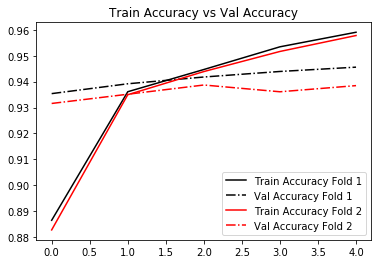

In [100]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.legend()
plt.show()  


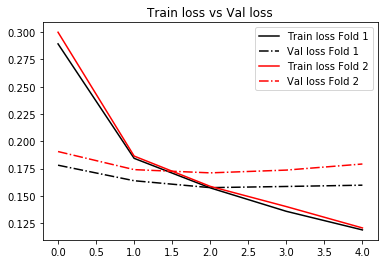

In [101]:
plt.title('Train loss vs Val loss')
plt.plot(model_history[0].history['loss'], label='Train loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val loss Fold 2', color='red', linestyle = "dashdot")
plt.legend()
plt.show()  

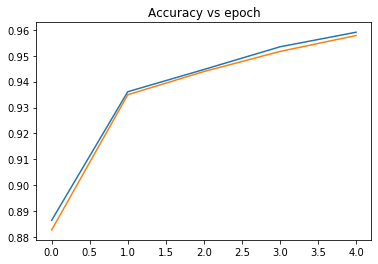

In [102]:

plt.title('Accuracy vs epoch')
plt.plot(model_history[0].history['acc'], label='Training Fold 1')
plt.plot(model_history[1].history['acc'], label='Training Fold 2')

Test

In [143]:
model = load_model('cnn_text.h5')
pred = model.predict(test_X)
y_hat = pred.argmax(axis=-1)
print(metrics.classification_report(test_y, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6902
           1       0.94      0.92      0.93      4977

    accuracy                           0.94     11879
   macro avg       0.94      0.94      0.94     11879
weighted avg       0.94      0.94      0.94     11879



In [108]:
model = load_model('cnn_text.h5')
print(model.evaluate(test_X, tf.keras.utils.to_categorical(test_y), verbose = 1))

11879/11879 [==============================] - 4s 326us/step
[0.1620062783616695, 0.9414092095294216]


In [131]:
auc = roc_auc_score(tf.keras.utils.to_categorical(test_y), pred.round() )
print('ROC AUC: %f' % auc)

ROC AUC: 0.938932
